# Aim of this jupyter notebook
Within this notebook  we read in the previous retrieved data and replace the cut of tweets  


actually this will only be a test run as we later only have to do so for tweets that are in a certain timer period 


In [2]:
from IPython.display import Image
import tweepy 
import csv
from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np

In [3]:
# for organisations with > 50M monthly visitors save name and screen name 
organisations = [["Yahoo News","YahooNews"],
                ["Huffington Post","HuffPost"],["CNN","CNN"],
                ["The New York Times","nytimes"],["Fox News","FoxNews"],
                ["NBC News","NBCNews"], ["Mail Online","MailOnline"]]


# latest tweet from googlenews was in October 2015, thus we removed 
# ["Google News","googlenews"]

In [4]:
# import previously retrieved data and retrive id of tweets that have been cut of 
#initialize names or organisations + twitter screen name
organisations = [["Yahoo News","YahooNews"],
                ["Huffington Post","HuffPost"],["CNN","CNN"],
                ["The New York Times","nytimes"],["Fox News","FoxNews"],
                ["NBC News","NBCNews"], ["Mail Online","MailOnline"]]

# set version of downloaded tweets (tweets have been derived at two different point of times)
time_strings = ["20201031_2114","20201220_0955"]

def create_df_for_each_retrieval(time_strings=time_strings,organisations = organisations):
    parser = lambda x: datetime.strptime(x,'%Y-%m-%d %X') 
    dict_orga_files = {}
    for time_string in time_strings:
       # what is this line for? dict_orga_files["df_{0}".format(orga[1].lower())]
        temp_orga_df = pd.DataFrame(columns=['agency', 'created_at', 'text'])
        for orga in organisations:
            with open(f'{time_string}_tweets_retrieved/{time_string}_{orga[1]}_tweets.csv', 
                  newline='') as f:
                temp_col_df = pd.read_csv(f, index_col=0,parse_dates =['created_at'],
                                      date_parser=parser)
                temp_col_df.insert(0,"agency",str(orga[1].lower()))

                #check if indices are unique 
                if not  temp_col_df.index.is_unique:
                    print("indices are  unique for",orga[1])

                temp_orga_df=temp_orga_df.append(temp_col_df)

                #check if indices are unique 
                if not  temp_orga_df.index.is_unique:
                    print("indices are  not unique in the joind df")
        dict_orga_files[f'df_all_orgas_{time_string}'] = temp_orga_df
        temp_list_return = list(dict_orga_files.values())
    return temp_list_return[0],temp_list_return[1]


In [5]:
df_20201031_2114,df_test_20201220_0955 = create_df_for_each_retrieval()

In [6]:
df_20201031_2114["date"]=df_20201031_2114["created_at"].dt.normalize() # introduce a column with only the date
df_test_20201220_0955["date"]=df_test_20201220_0955["created_at"].dt.normalize()

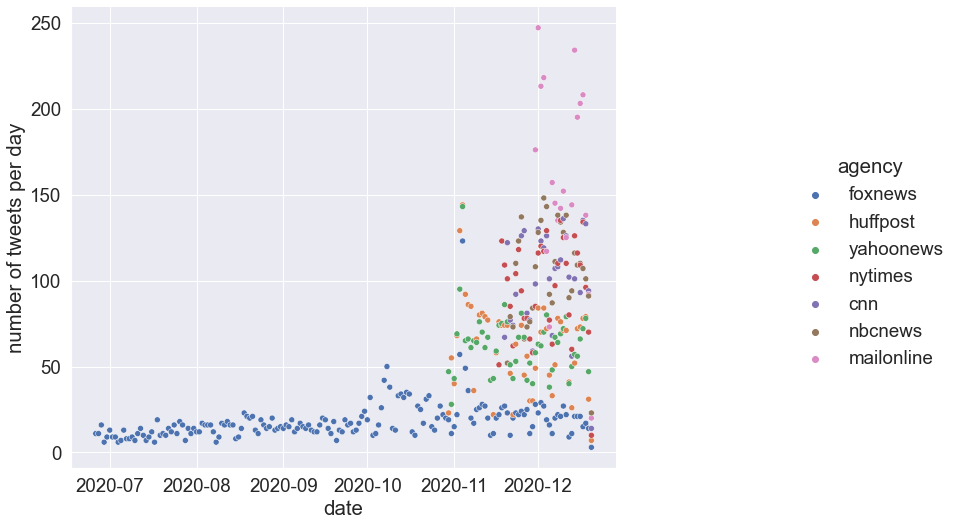

In [7]:
# get number per tweets per organization and date 

group_by_orga_date = df_test_20201220_0955.groupby(["date","agency"]).text.count() 

# visualize the number per tweets per organization and date
%matplotlib inline 
sns.set(font_scale=1.7)
g= sns.relplot(x=group_by_orga_date.index.get_level_values(0),
            y=group_by_orga_date.values, hue = group_by_orga_date.index.get_level_values(1),
            data=group_by_orga_date) 

g.set( ylabel='number of tweets per day')
g.fig.set_size_inches(15,8)

### Interpretation
As the twitter api only allows a certain number of tweets to be retrieved and foxnews did not post as many tweets on the same day as the other agencies, the time of the first date of a tweet varies a lot amongst all agencies. 


This large time gap  between foxnews and the other agencies might interfere with the process of identifying the authoer of a tweet based on tpic featues. This is because these early tweets from foxnews probably covers topics that the other don´t. It has been therefore decided to keep only the tweets for overlapping time periods, which can be seen in the following cells. 

The large gap in foxnews tweets between the first two and the other tweets, are due to a twitter pause of this agency.



In [8]:
# compare the first date that was recorded for the respective organizations in the respective dataset 
df_group_by_orga_20201220_0955 = df_test_20201220_0955.groupby("agency")
temp_df_20201220_0955= df_group_by_orga_20201220_0955.min()['created_at'] 
df_group_by_orga_20201031_2114 = df_20201031_2114.groupby("agency")
temp_df_20201031_2114= df_group_by_orga_20201031_2114.min()['created_at'] 
temp_df_20201031_2114 = temp_df_20201031_2114[temp_df_20201031_2114.index != "foxnews"]


print("Tweets for 20201220_0955 data \twere recorded from:\t\n")
print(temp_df_20201220_0955)
first_min_20201220_0955 = min(temp_df_20201220_0955)
first_max_20201220_0955 = max(temp_df_20201220_0955)

print("\nThe earliest first recording of an organization was on ", first_min_20201220_0955.date(),
      "and the latest first record on ",first_max_20201220_0955.date(),
     "thus we have a difference of ",(first_max_20201220_0955-first_min_20201220_0955).days,"days")

print("Tweets for 20201031_2114 data \twere recorded from:\t\n")
print(temp_df_20201031_2114)
first_min_20201031_2114 = min(temp_df_20201031_2114)
first_max_20201031_2114 = max(temp_df_20201031_2114)

print("\nThe earliest first recording of an organization was on ", first_min_20201031_2114.date(),
      "and the latest first record on ",first_max_20201031_2114.date(),
     "thus we have a difference of ",(first_max_20201031_2114-first_min_20201031_2114).days,"days")

# cut the dataframes to start for the first_max date: 
df_20201031_2114 = df_20201031_2114[df_20201031_2114["created_at"]>first_max_20201031_2114]
df_test_20201220_0955 = df_test_20201220_0955[df_test_20201220_0955["created_at"]>first_max_20201220_0955]

Tweets for 20201220_0955 data 	were recorded from:	

agency
cnn          2020-11-19 11:46:07
foxnews      2020-06-26 00:18:10
huffpost     2020-10-30 17:41:00
mailonline   2020-11-30 09:10:02
nbcnews      2020-11-20 14:29:04
nytimes      2020-11-17 20:10:02
yahoonews    2020-10-30 12:15:02
Name: created_at, dtype: datetime64[ns]

The earliest first recording of an organization was on  2020-06-26 and the latest first record on  2020-11-30 thus we have a difference of  157 days
Tweets for 20201031_2114 data 	were recorded from:	

agency
cnn          2020-10-03 22:45:05
huffpost     2020-09-16 07:48:12
mailonline   2020-10-12 13:04:56
nbcnews      2020-10-07 10:14:04
nytimes      2020-09-30 03:50:03
yahoonews    2020-09-08 23:45:03
Name: created_at, dtype: datetime64[ns]

The earliest first recording of an organization was on  2020-09-08 and the latest first record on  2020-10-12 thus we have a difference of  33 days


In [9]:
def visualize_result(df):
    # get number per tweets per organization and date 
    df_grouped = df.groupby(["date","agency"]).text.count() 

    # visualize the number per tweets per organization and date
    %matplotlib inline 
    g= sns.relplot(x=df_grouped.index.get_level_values(0),
                y=df_grouped.values, 
                   hue = df_grouped.index.get_level_values(1),
                data=df_grouped,kind="line") 

    g.set( ylabel='number of tweets per day')
    g.fig.set_size_inches(15,8) 
    pass

def tweets_left_overview(df):
    df_by_agency = df.groupby("agency")

    remaining_tweets_abs = df_by_agency.text.count()
    remaining_tweets_total = sum(remaining_tweets_abs)
    remaining_tweets_rel = remaining_tweets_abs/remaining_tweets_total

    print("The following number of tweets remain per",remaining_tweets_abs,
         "\n\nthis makes in total",remaining_tweets_total,"tweets\n",
         "\nshare of remaining tweets per",remaining_tweets_rel)
    pass

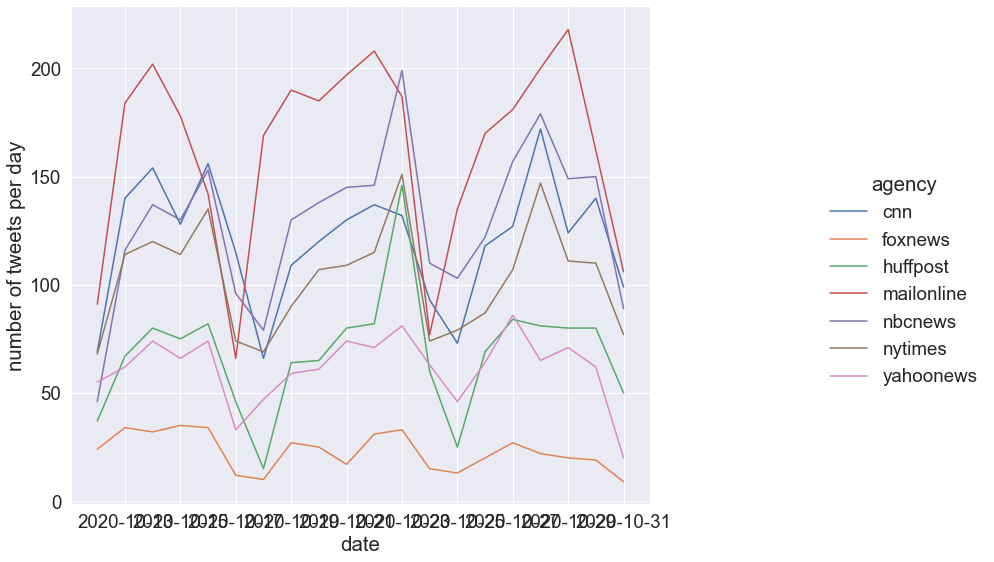

In [10]:
visualize_result(df_20201031_2114)

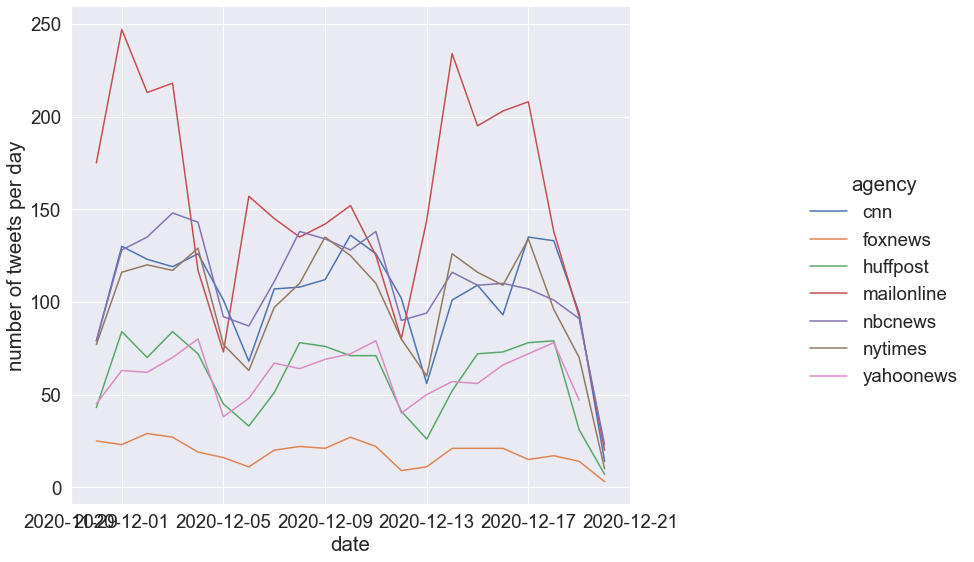

In [11]:
visualize_result(df_test_20201220_0955)

In [12]:
df_joint = pd.concat([df_test_20201220_0955,df_20201031_2114], axis=0)

In [13]:
tweets_left_overview(df_joint)

The following number of tweets remain per agency
cnn           4574
foxnews        853
huffpost      2605
mailonline    6461
nbcnews       4876
nytimes       4135
yahoonews     2457
Name: text, dtype: int64 

this makes in total 25961 tweets
 
share of remaining tweets per agency
cnn           0.176187
foxnews       0.032857
huffpost      0.100343
mailonline    0.248873
nbcnews       0.187820
nytimes       0.159277
yahoonews     0.094642
Name: text, dtype: float64


# Tweets that only got imported half and RT

In [14]:
# remove tweet with tweet id 1316397145038127106 as it is no longer available 
# and would cause troubles further down the code
df_joint= df_joint[df_joint.index != 1316397145038127106]


In [15]:
# create a new data frame forthat only include cut off tweets
three_dots_in_string = lambda x: chr(8230) in x
rt_tweet = lambda x: "RT @" in x
df_joint["ascii_8230"] = df_joint.text.apply(three_dots_in_string)
df_joint["RT"] =  df_joint.text.apply(rt_tweet)
df_no_RT = df_joint[df_joint.RT==False]
df_without_cut_off = df_no_RT[df_no_RT.ascii_8230==False]
df_cut_off = df_no_RT[df_no_RT.ascii_8230]
id_to_filter_for = df_cut_off.index
assert len(df_without_cut_off) +len(id_to_filter_for) == len(df_no_RT)

In [20]:
def fill_in_cut_tweets(i_start,df_cut_off):
    #Twitter API credentials
    consumer_key = "Y5zMznYw7AjpWbfxrxJZ0uVAo"
    consumer_secret= "ri7MHYgEEXfGsBHMHmE1TxLGhmKiZR3H12ZVUhyuvKrW1KmGh3"  
    access_key = "1320942553013886978-yHLA8KWdWh7QSxlFCtCfyy6wpZ3Yao"
    access_secret = "zuTivL21gElRGTcPzQHWNoqdSHcEXgHa58Ga9QekmVtmp"

    # source partly depends on: http://docs.tweepy.org/en/latest/extended_tweets.html

    # collect ids for which no tweet was found
    weired_ids=[]

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
        # following line modified
    api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

    temp_full_length_tweets = []
    range_max = min(1182,len(df_cut_off)-i_start)
    for i in range(range_max):  
        i_updated = i + i_start
        id = df_cut_off.index[i_updated]
        status = api.get_status(id, tweet_mode="extended")

        try:
            full_text = status.retweeted_status.full_text
        except AttributeError:  # Not a Retweet
            full_text = status.full_text
        temp_full_length_tweets.append(full_text)
    return temp_full_length_tweets


In [19]:
# apply fill_in_cut_tweets
# Important: this cell runs for multiple hours as only 900 tweets can be downloaded per 15 min
# remove the # in the following line to run this cell
#for i_start in [1182*x for x in range(10)]:
    total_retweets= []
    temp_array_full_tweets = fill_in_cut_tweets(i_start,df_cut_off)
    print("starting from",i_start,"is finished")
    total_retweets.extend(temp_array_full_tweets)
    
df_cut_offs_filled_in = df_cut_off
df_cut_offs_filled_in["text"] = total_retweets

Rate limit reached. Sleeping for: 716


starting from 0 is finished


Rate limit reached. Sleeping for: 722


starting from 1182 is finished


Rate limit reached. Sleeping for: 715


starting from 2364 is finished


Rate limit reached. Sleeping for: 724
Rate limit reached. Sleeping for: 722


starting from 3546 is finished


Rate limit reached. Sleeping for: 716


starting from 4728 is finished


Rate limit reached. Sleeping for: 722


starting from 5910 is finished


Rate limit reached. Sleeping for: 724
Rate limit reached. Sleeping for: 723


starting from 7092 is finished


Rate limit reached. Sleeping for: 722


starting from 8274 is finished


Rate limit reached. Sleeping for: 716


starting from 9456 is finished


Rate limit reached. Sleeping for: 723
Rate limit reached. Sleeping for: 724


starting from 10638 is finished


ValueError: Length of values (1181) does not match length of index (11819)

In [21]:
# save back to csv only the full length tweets 
#(do not include RT because they might slightly vary in terms of topic)
df_all_full_without_rt = pd.concat([df_cut_offs_filled_in,df_without_cut_off],axis=0)
df_all_full_without_rt.drop(["ascii_8230","RT"],axis =1,inplace=True)
df_all_full_without_rt.to_csv("full_tweets_without_rt.xlsx",index=True)